# OntoVAE workflow

In [2]:
# import modules
import sys
import os
import pickle
import torch
from onto_vae.ontobj import *
from onto_vae.vae_model import *

## 1. Creation of Ontology object

First, we need to initialize an Ontobj. This is required by OntoVAE to initialize latent space and decoder and train the model. The Ontobj stores information about the used ontology, and also datasets that were matched to this ontology so that they can be used for trainind or passed through the VAE model.

In [3]:
# initialize the Ontobj
# the description should be an identifier, e.g. the ontology used, here: PWO (Pathway Ontology)
pwo = Ontobj(description='PWO')

In [4]:
# initialize our ontology
# obo: path to an obo file
# gene_annot: path to a tab separated file with two columns: Genes and Ontology IDs
pwo.initialize_dag(obo=sys.path[0] + '/onto_vae/data/pw.obo',
                   gene_annot=sys.path[0] + '/onto_vae/data/gene_term_mapping.txt')

In [5]:
# trim the ontology
pwo.trim_dag(top_thresh=1000, 
             bottom_thresh=30)

In [6]:
# create masks for decoder initialization
pwo.create_masks(top_thresh=1000,
                 bottom_thresh=30)

In [7]:
# match a dataset to the ontology
# expr_path: path to the dataset (either h5ad)
pwo.match_dataset(expr_data = sys.path[0] + '/onto_vae/data/pbmc_sample_expr.csv',
                  name='PBMC_CD4T')

## 2. OntoVAE model training

In [9]:
# initialize OntoVAE 
pwo_model = OntoVAE(ontobj=pwo,              # the Ontobj we will use
                    dataset='PBMC_CD4T',     # which dataset from the Ontobj to use for model training
                    top_thresh=1000,         # which trimmed version to use
                    bottom_thresh=30)        # which trimmed version to use              

In [10]:
# generate a directory where to store the best model
if not os.path.isdir(sys.path[0] + '/onto_vae/data/models'):
    os.mkdir(sys.path[0] + '/onto_vae/data/models')

In [17]:
# train the model
pwo_model.train_model(sys.path[0] + '/onto_vae/data/models/best_model.pt',   # where to store the best model
                     lr=1e-4,                                                # the learning rate
                     kl_coeff=1e-4,                                          # the weighting coefficient for the Kullback Leibler loss
                     batch_size=128,                                         # the size of the minibatches
                     epochs=5,                                               # over how many epochs to train
                     log=False)                                              # whether run should be logged to Neptune

Epoch 1 of 5


100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.08it/s]


New best model!
Train Loss: 11326.5905
Val Loss: 9154.0938
Epoch 2 of 5


100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.06it/s]


New best model!
Train Loss: 11332.0335
Val Loss: 9056.0139
Epoch 3 of 5


100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.44it/s]


New best model!
Train Loss: 11252.8631
Val Loss: 9013.7158
Epoch 4 of 5


100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.75it/s]


Train Loss: 11265.1621
Val Loss: 9098.4927
Epoch 5 of 5


100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 33.54it/s]

Train Loss: 11306.3646
Val Loss: 9077.7239


## 3. Analysis with OntoVAE model (pathway activities + perturbations)

We can use a trained OntoVAE model to retrieve pathway activities from latent space and decoder, but also to perform in silico perturbations prior to retrieving the pathway activities.

In [10]:
# load the best model
checkpoint = torch.load(sys.path[0] + '/onto_vae/data/models/best_model.pt')
pwo_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
# retrieve pathway activities
pwo_act = pwo_model.get_pathway_activities(ontobj=pwo,
                                           dataset='PBMC_CD4T')

We can use a function of the Ontobj to make an example scatterplot for two pathways of our choice.

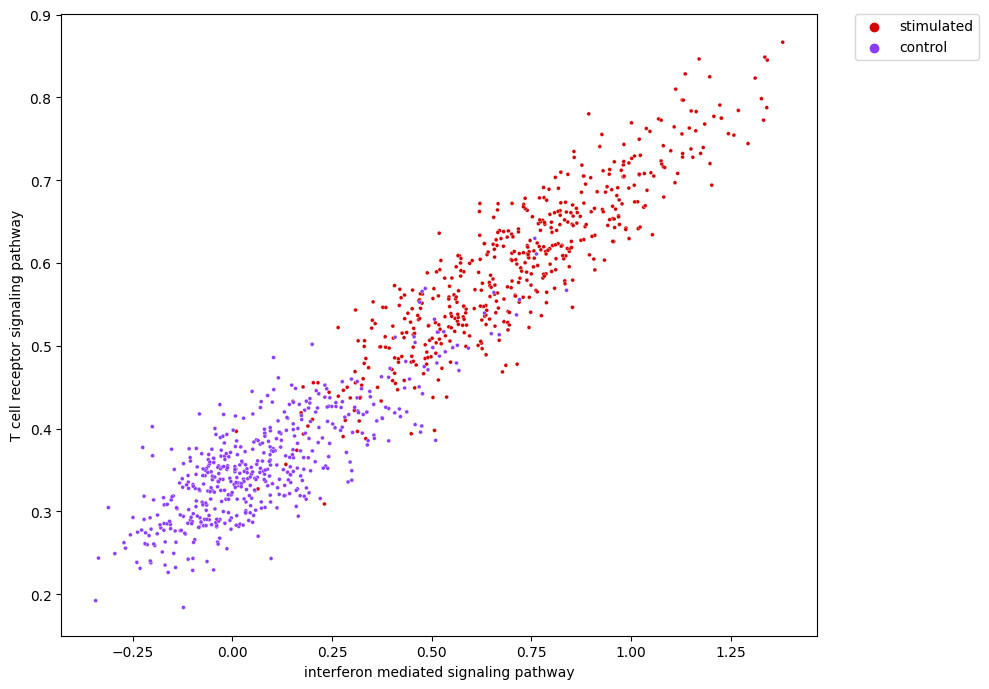

In [29]:
# make scatterplot for two pathway activities
pwo.plot_scatter(sample_annot = sys.path[0] + '/onto_vae/data/pbmc_sample_annot.csv', # pandas Dataframe or path to annotation file
                 color_by = 'condition',                                              # variable to use for coloring
                 act = pwo_act,                                                       # pathway activities computed from OntoVAE model
                 term1 = 'interferon mediated signaling pathway',                     # term on x-axis of scatter plot
                 term2 = 'T cell receptor signaling pathway',                         # term on y-axis of scatter plot
                 top_thresh = 1000,                                                   # which trimmed version to use
                 bottom_thresh = 30)                                                  # which trimmed version to use

# Note that the scatterplot displayed in the vignette was trained over 200 epochs!

We can now perform in silico perturbations and Wilcoxon tests to see which terms are influenced most.

In [12]:
# get pathway activities where ISG15 was perturbed
pwo_ko_act = pwo_model.perturbation(ontobj=pwo,
                                    dataset='PBMC_CD4T',
                                    genes=['ISG15'],        # list of genes to be perturbed
                                    values=[0])             # list of new values for the genes

We can use a function of the Ontobj to perform a paired Wilcoxon test between perturbed and non-perturbed for all terms of the ontology and get a ranked dataframe

In [13]:
# perform paired Wilcoxon test
results = pwo.wilcox_test(dataset='PBMC_CD4T',
                          act = pwo_act,
                          perturbed_act = pwo_ko_act,
                          direction = 'down',
                          top_thresh=1000,
                          bottom_thresh=30)

In [16]:
# display the top results
results.head(10)

,id,term,depth,stat,pval,qval
426,PW:0000817,NOD-like receptor signaling pathway,5,53649.5,5.018339e-103,1.464068e-100
425,PW:0000816,Retinoic acid-inducible gene (RIG) I-like rece...,5,53812.0,7.363690e-103,1.464068e-100
298,PW:0000925,pattern recognition receptor mediated signalin...,4,53856.0,8.168918e-103,1.464068e-100
424,PW:0000814,Toll-like receptor signaling pathway,5,53893.0,8.913653e-103,1.464068e-100
45,PW:0000818,signaling pathway pertinent to immunity,0,57527.0,4.334615e-99,5.695683e-97
6,PW:0000024,inflammatory response pathway,0,59055.0,1.467959e-97,1.607416e-95
557,PW:0000233,tumor necrosis factor mediated signaling pathway,6,59443.0,3.574639e-97,3.269452e-95
78,PW:0000926,pro-inflammatory cytokine mediated pathway,1,59490.0,3.981068e-97,3.269452e-95
562,PW:0000516,interleukin-6 signaling pathway,6,59630.0,5.485784e-97,4.004623e-95
571,PW:0000883,interleukin-1 signaling pathway,6,59883.5,9.797201e-97,6.436761e-95


We see that when we modulate ISG15 expression, our top hits are all pathways related to the immune response!